### Description of datasets

channels: This dataset contains information about the sales channels (marketplaces) where our store owners sell their goods and food.

deliveries: This dataset contains information about the deliveries made by our partner delivery drivers.

drivers: This dataset contains information about the partner delivery drivers. They are stationed at our hubs, and every time an order is processed, they make the deliveries to the consumers' homes.

hubs: This dataset contains information about the Delivery Center hubs. Hubs are the distribution centers for 
orders, and deliveries originate from there.

orders: This dataset contains information about the sales processed through the Delivery Center platform.

payments: This dataset contains information about the payments made to the Delivery Center.

stores: This dataset contains information about the store owners. They use the Delivery Center platform to sell their items (goods and/or food) on the marketplaces.### 

## 1.Create Pyspark session, load datasets

In [81]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
spark = SparkSession.builder.appName("hdfs_test").config("spark.sql.execution.arrow.pyspark.enabled", "true").getOrCreate()

24/04/25 12:48:32 WARN Utils: Your hostname, MacBook-Air-Paulina.local resolves to a loopback address: 127.0.0.1; using 192.168.0.101 instead (on interface en0)
24/04/25 12:48:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/25 12:48:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
files = ['channels', 'deliveries', 'drivers', 'hubs', 'orders', 'payments', 'stores']
dfs = {}

for file in files:
    dfs[file] = spark.read.csv("hdfs://localhost:9000/user/maciek/"+file+".csv", header=True, inferSchema=True)

In [4]:
channels = dfs['channels']
deliveries = dfs['deliveries']
hubs = dfs['hubs']
drivers = dfs['drivers']
orders = dfs['orders']
payments = dfs['payments']
stores = dfs['stores']

## 2.Inspect datasets, its structure and missing values

##### Channels

In [5]:
channels.show()

+----------+--------------+------------+
|channel_id|  channel_name|channel_type|
+----------+--------------+------------+
|         1|   OTHER PLACE| OWN CHANNEL|
|         2|   PHONE PLACE| OWN CHANNEL|
|         3|   WHATS PLACE| OWN CHANNEL|
|         4|    FACE PLACE| OWN CHANNEL|
|         5|    FOOD PLACE| MARKETPLACE|
|         6|   STORE PLACE| OWN CHANNEL|
|         7|  BERLIN PLACE| OWN CHANNEL|
|         8|  MADRID PLACE| OWN CHANNEL|
|         9|   THINK PLACE| OWN CHANNEL|
|        10|  LISBON PLACE| OWN CHANNEL|
|        11|   SUPER PLACE| OWN CHANNEL|
|        12|     ALL PLACE| MARKETPLACE|
|        13|VELOCITY PLACE| MARKETPLACE|
|        15|    EATS PLACE| MARKETPLACE|
|        17|   SHOPP PLACE| MARKETPLACE|
|        20|  MUNICH PLACE| MARKETPLACE|
|        21|  LONDON PLACE| MARKETPLACE|
|        23|  ATCHIN PLACE| MARKETPLACE|
|        24|    FULL PLACE| MARKETPLACE|
|        25|      ON PLACE| MARKETPLACE|
+----------+--------------+------------+
only showing top

In [6]:
from pyspark.sql import functions as F


print(f"channel_name number: {channels.select('channel_name').distinct().count()}\n")

### unique values occurance 
grouped_data = channels.groupBy('channel_name').agg(F.count('*').alias('count'))
print(f"unique values in channel name column: {grouped_data.count()}\n")

### null values number for each value in channel name
nul_vals_cn = channels.groupBy('channel_name').agg(F.sum(F.col('channel_name').isNull().cast("int")).alias("null_count")).collect()
for row in nul_vals_cn:
    print(f"{row['channel_name']} null values: {row['null_count']}")

### total null values number in each column
tot_nan_vals = channels.select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in channels.columns)).collect()[0].asDict()
print(f"\nnumber of unique values in each column:\n {tot_nan_vals}")


channel_name number: 40

unique values in channel name column: 40

FOOD PLACE null values: 0
FACE PLACE null values: 0
LONGO PLACE null values: 0
CENTER PLACE null values: 0
ALL PLACE null values: 0
RONALD PLACE null values: 0
FULL PLACE null values: 0
PORTO PLACE null values: 0
SUPER PLACE null values: 0
VELOCITY PLACE null values: 0
AHORA PLACE null values: 0
SEARCH PLACE null values: 0
GLUB PLACE null values: 0
CAICAI PLACE null values: 0
OTHER PLACE null values: 0
BERLIN PLACE null values: 0
BEATLES PLACE null values: 0
ON PLACE null values: 0
SPEED PLACE null values: 0
LONDON PLACE null values: 0
WEAR PLACE null values: 0
SAN PLACE null values: 0
LISBON PLACE null values: 0
SHOPP PLACE null values: 0
RIBA PLACE null values: 0
STORE PLACE null values: 0
MUNICH PLACE null values: 0
REGISTER PLACE null values: 0
OWN PLACE null values: 0
MADRID PLACE null values: 0
THINK PLACE null values: 0
EATS PLACE null values: 0
ATCHIN PLACE null values: 0
OFF PLACE null values: 0
BRAZIL PLACE nu

##### Dliveries

In [8]:
print(deliveries.describe().show())
deliveries.show()

24/04/24 17:19:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-------------------+------------------+------------------------+---------------+
|summary|      delivery_id|  delivery_order_id|         driver_id|delivery_distance_meters|delivery_status|
+-------+-----------------+-------------------+------------------+------------------------+---------------+
|  count|           378843|             378843|            362957|                  378770|         378843|
|   mean| 2634216.36283896|8.220422339218093E7| 21001.77764308169|      10721.360044354093|           NULL|
| stddev|264655.3209144291|  6996909.141038616|15520.652243004235|       231539.1894589949|           NULL|
|    min|          2174658|           68409030|               133|                       0|      CANCELLED|
|    max|          3144739|           93139817|             66459|                 7251291|     DELIVERING|
+-------+-----------------+-------------------+------------------+------------------------+---------------+

None
+-----------+---------

In [9]:
print(f"delivery status distinct number: {deliveries.select('delivery_status').distinct().count()}\n")

### unique values occurance 
grouped_data = deliveries.groupBy('delivery_status').agg(F.count('*').alias('count'))
print(f"unique values in delivery status column: {grouped_data.count()}\n")

### total null values number in each column
tot_nan_vals = deliveries.select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in deliveries.columns)).collect()[0].asDict()
print(type(tot_nan_vals))
for key, val in tot_nan_vals.items():
   print(f"number of null values in  column {key}: {val}\n")


delivery status distinct number: 3

unique values in delivery status column: 3

<class 'dict'>
number of null values in  column delivery_id: 0

number of null values in  column delivery_order_id: 0

number of null values in  column driver_id: 15886

number of null values in  column delivery_distance_meters: 73

number of null values in  column delivery_status: 0



##### Hubs

In [11]:
print(hubs.describe().show())
hubs.show(32)

+-------+----------------+---------------+---------+---------+-----------------+-----------------+
|summary|          hub_id|       hub_name| hub_city|hub_state|     hub_latitude|    hub_longitude|
+-------+----------------+---------------+---------+---------+-----------------+-----------------+
|  count|              32|             32|       32|       32|               32|               32|
|   mean|        34.40625|           NULL|     NULL|     NULL|-24.4207382740625|   -46.5114598125|
| stddev|24.9035032838043|           NULL|     NULL|     NULL|2.289950688834545|2.668164650441109|
|    min|               2|AVENUE SHOPPING| CURITIBA|       PR|       -30.085743|       -51.245997|
|    max|              91|  WOLF SHOPPING|S�O PAULO|       SP|      -22.8858199|      -43.1821807|
+-------+----------------+---------------+---------+---------+-----------------+-----------------+

None
+------+----------------+--------------+---------+------------+-------------+
|hub_id|        hub_name|

##### Drivers

In [13]:
print(drivers.describe().show())
drivers.show()

+-------+------------------+------------+-----------------+
|summary|         driver_id|driver_modal|      driver_type|
+-------+------------------+------------+-----------------+
|  count|              4824|        4824|             4824|
|   mean|29681.790008291875|        NULL|             NULL|
| stddev| 18391.79806919864|        NULL|             NULL|
|    min|               133|       BIKER|        FREELANCE|
|    max|             66494|     MOTOBOY|LOGISTIC OPERATOR|
+-------+------------------+------------+-----------------+

None
+---------+------------+-----------------+
|driver_id|driver_modal|      driver_type|
+---------+------------+-----------------+
|      133|     MOTOBOY|LOGISTIC OPERATOR|
|      138|     MOTOBOY|        FREELANCE|
|      140|     MOTOBOY|        FREELANCE|
|      143|       BIKER|        FREELANCE|
|      148|     MOTOBOY|        FREELANCE|
|      165|     MOTOBOY|        FREELANCE|
|      172|     MOTOBOY|        FREELANCE|
|      174|       BIKER|

In [14]:
d_modal_vls = drivers.select('driver_modal').distinct().count()
print(f"unique values in driver modal column: {d_modal_vls}")

unique values in driver modal column: 2


##### Orders

In [16]:
#print(orders.describe().show())
print(len(orders.columns))
print(orders.columns)

29
['order_id', 'store_id', 'channel_id', 'payment_order_id', 'delivery_order_id', 'order_status', 'order_amount', 'order_delivery_fee', 'order_delivery_cost', 'order_created_hour', 'order_created_minute', 'order_created_day', 'order_created_month', 'order_created_year', 'order_moment_created', 'order_moment_accepted', 'order_moment_ready', 'order_moment_collected', 'order_moment_in_expedition', 'order_moment_delivering', 'order_moment_delivered', 'order_moment_finished', 'order_metric_collected_time', 'order_metric_paused_time', 'order_metric_production_time', 'order_metric_walking_time', 'order_metric_expediton_speed_time', 'order_metric_transit_time', 'order_metric_cycle_time']


##### Payments

In [18]:
print(payments.describe().show())
payments.show()

+-------+------------------+-------------------+------------------+------------------+----------------+--------------+
|summary|        payment_id|   payment_order_id|    payment_amount|       payment_fee|  payment_method|payment_status|
+-------+------------------+-------------------+------------------+------------------+----------------+--------------+
|  count|            400834|             400834|            400834|            400659|          400834|        400834|
|   mean|4951200.0591092575|8.234181374782579E7| 93.08926119043774|1.8805104839776046|            NULL|          NULL|
| stddev|  301492.397809497|  7002740.920972272|221.94716737607547|4.5400129754679295|            NULL|          NULL|
|    min|           4427917|           68410055|               0.0|               0.0|BANK_TRANSFER_DC|      AWAITING|
|    max|           5540806|           93139817|         100000.11|            2000.0|   VOUCHER_STORE|          PAID|
+-------+------------------+-------------------+

In [19]:
status_un = payments.select('payment_status').distinct().count()
print(status_un)
vls_occ = payments.groupBy('payment_status').agg(F.sum(F.col('payment_status').isNull().cast("int")).alias('null_vls')).collect()
for row in vls_occ:
    print(f"number of null values in {row['payment_status']} column: {row['null_vls']}")

payment_gb = payments.groupBy('payment_status').agg(F.count('*').alias('number'))
print(payment_gb.show())

CodeCache: size=131072Kb used=41163Kb max_used=41174Kb free=89908Kb
 bounds [0x00000001061e8000, 0x0000000108a68000, 0x000000010e1e8000]
 total_blobs=14814 nmethods=13810 adapters=915
 compilation: disabled (not enough contiguous free space left)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


3
number of null values in CHARGEBACK column: 0
number of null values in PAID column: 0
number of null values in AWAITING column: 0
+--------------+------+
|payment_status|number|
+--------------+------+
|    CHARGEBACK|   438|
|          PAID|400381|
|      AWAITING|    15|
+--------------+------+

None


##### Stores

In [21]:
print(stores.describe().show())
stores.show()

+-------+------------------+------------------+--------------+-------------+-----------------+------------------+------------------+
|summary|          store_id|            hub_id|    store_name|store_segment| store_plan_price|    store_latitude|   store_longitude|
+-------+------------------+------------------+--------------+-------------+-----------------+------------------+------------------+
|  count|               951|               951|           951|          951|              836|               935|               935|
|   mean|2080.5552050473184| 30.37539432176656|          NULL|         NULL| 34.8165311004786|-23.88641021835297|-46.04286869650257|
| stddev|1338.5905906279252|18.961983691118437|          NULL|         NULL|14.30408567487769|1.5583846446157017|2.2980003371948903|
|    min|                 3|                 2|ACA PRISSURAU |         FOOD|              0.0|        -30.085743|        -51.245997|
|    max|              4679|                91|�RPIR PILMACI |       

In [22]:
shops = stores.groupBy('store_segment').agg(F.count('*').alias('shops_num'))
print(shops.show())

+-------------+---------+
|store_segment|shops_num|
+-------------+---------+
|         FOOD|      384|
|         GOOD|      567|
+-------------+---------+

None


## 3.Working with data plan
1. how many orders are canceled (before payment, after payment)
2. What's average time of delivery for food and good, take into account distance of delivery and type of transp
3. Average amount for food and good order
4. Average amount for each store, number of orders for each store and for each hub
5. Total incomes per store and total number of orders for each store easch month

### 3.1.Number of finished and canceled orders

In [104]:
print(orders.columns)

['order_id', 'store_id', 'channel_id', 'payment_order_id', 'delivery_order_id', 'order_status', 'order_amount', 'order_delivery_fee', 'order_delivery_cost', 'order_created_hour', 'order_created_minute', 'order_created_day', 'order_created_month', 'order_created_year', 'order_moment_created', 'order_moment_accepted', 'order_moment_ready', 'order_moment_collected', 'order_moment_in_expedition', 'order_moment_delivering', 'order_moment_delivered', 'order_moment_finished', 'order_metric_collected_time', 'order_metric_paused_time', 'order_metric_production_time', 'order_metric_walking_time', 'order_metric_expediton_speed_time', 'order_metric_transit_time', 'order_metric_cycle_time']


In [105]:
order_st = orders.groupBy('order_status').agg(F.count('*').alias('number'))
print(order_st.show())

+------------+------+
|order_status|number|
+------------+------+
|    FINISHED|352020|
|    CANCELED| 16979|
+------------+------+

None


### 3.2.Average time of delivery

In [6]:
delivery_time = deliveries.join(drivers, 'driver_id', 'inner')
delivery_time = orders.join(delivery_time, 'delivery_order_id', 'inner')
delivery_time = delivery_time.join(stores, 'store_id', 'inner')
delivery_time = delivery_time.select('order_id',                                                                                
                                     'order_amount',
                                     'order_moment_created',
                                     'order_moment_ready',
                                     'order_moment_finished',
                                     'order_status',
                                     'delivery_order_id',
                                     'driver_id',
                                     'driver_modal',
                                     'delivery_distance_meters',
                                     'delivery_status',
                                     'store_id',
                                     'store_segment'
                                    ).filter((delivery_time['order_status']=='FINISHED') &
                                             (delivery_time['delivery_status']=='DELIVERED'))

delivery_time.show(2)

+--------+------------+--------------------+-------------------+---------------------+------------+-----------------+---------+------------+------------------------+---------------+--------+-------------+
|order_id|order_amount|order_moment_created| order_moment_ready|order_moment_finished|order_status|delivery_order_id|driver_id|driver_modal|delivery_distance_meters|delivery_status|store_id|store_segment|
+--------+------------+--------------------+-------------------+---------------------+------------+-----------------+---------+------------+------------------------+---------------+--------+-------------+
|68414309|        94.9| 1/1/2021 2:21:02 PM|1/1/2021 2:36:49 PM|  1/1/2021 2:50:20 PM|    FINISHED|         68414309|     2473|       BIKER|                     410|      DELIVERED|     236|         FOOD|
|68415344|        83.4| 1/1/2021 2:33:32 PM|1/1/2021 2:56:25 PM|  1/1/2021 4:18:52 PM|    FINISHED|         68415344|    26154|     MOTOBOY|                    5385|      DELIVERED

In [7]:
delivery_time.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- order_amount: double (nullable = true)
 |-- order_moment_created: string (nullable = true)
 |-- order_moment_ready: string (nullable = true)
 |-- order_moment_finished: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- delivery_order_id: integer (nullable = true)
 |-- driver_id: integer (nullable = true)
 |-- driver_modal: string (nullable = true)
 |-- delivery_distance_meters: integer (nullable = true)
 |-- delivery_status: string (nullable = true)
 |-- store_id: integer (nullable = true)
 |-- store_segment: string (nullable = true)



#### 3.2.1.Calculate preparing and delivery time

In [8]:
### to timestamp type
delivery_time = delivery_time.withColumn('order_moment_created', F.to_timestamp(
    'order_moment_created', 'M/d/yyyy h:mm:ss a'))
delivery_time = delivery_time.withColumn('order_moment_ready', F.to_timestamp(
    'order_moment_ready', 'M/d/yyyy h:mm:ss a'))
delivery_time = delivery_time.withColumn('order_moment_finished', F.to_timestamp(
    'order_moment_finished', 'M/d/yyyy h:mm:ss a'))

### to unix-timestamp type
delivery_time = delivery_time.withColumn('order_moment_created', F.unix_timestamp(
    'order_moment_created'))
delivery_time = delivery_time.withColumn('order_moment_ready', F.unix_timestamp(
    'order_moment_ready'))
delivery_time = delivery_time.withColumn('order_moment_finished', F.unix_timestamp(
    'order_moment_finished'))

In [9]:
### calculate preparing and delivering times
delivery_time = delivery_time.withColumn('delivery_preparing_time', 
                                         delivery_time['order_moment_ready']-delivery_time['order_moment_created'])
delivery_time = delivery_time.withColumn('delivery_time', 
                                         delivery_time['order_moment_finished']-delivery_time['order_moment_ready'])
delivery_time.show(2)

+--------+------------+--------------------+------------------+---------------------+------------+-----------------+---------+------------+------------------------+---------------+--------+-------------+-----------------------+-------------+
|order_id|order_amount|order_moment_created|order_moment_ready|order_moment_finished|order_status|delivery_order_id|driver_id|driver_modal|delivery_distance_meters|delivery_status|store_id|store_segment|delivery_preparing_time|delivery_time|
+--------+------------+--------------------+------------------+---------------------+------------+-----------------+---------+------------+------------------------+---------------+--------+-------------+-----------------------+-------------+
|68414309|        94.9|          1609507262|        1609508209|           1609509020|    FINISHED|         68414309|     2473|       BIKER|                     410|      DELIVERED|     236|         FOOD|                    947|          811|
|68415344|        83.4|         

#### 3.2.2.Create heatmap with delivery time

In [11]:
### using ml to convert driver modal values to numerical

from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

string_indexer1 = StringIndexer(inputCol="driver_modal", outputCol="driver_modal_indexer")
string_indexer2 = StringIndexer(inputCol="store_segment", outputCol="store_segment_indexer")

one_hot_encoder1 = OneHotEncoder(inputCol="driver_modal_indexer", outputCol="driver_modal_encoded")
one_hot_encoder2 = OneHotEncoder(inputCol="store_segment_indexer", outputCol="store_segment_encoded")

pipeline = Pipeline(stages=[string_indexer1, string_indexer2, one_hot_encoder1, one_hot_encoder2])

delivery_time_transf = pipeline.fit(delivery_time).transform(delivery_time)

In [12]:
### droping NaN values and round order amount
from pyspark.sql.types import IntegerType

print(delivery_time_transf.count())

delivery_time_transf_no_nan = delivery_time_transf.dropna()

print(delivery_time_transf_no_nan.count())

delivery_time_transf_no_nan = delivery_time_transf_no_nan.withColumn("order_amount", F.round(delivery_time_transf_no_nan["order_amount"], 0).cast(IntegerType()))                                                   

361028


350955


In [13]:

delivery_df = delivery_time_transf_no_nan.toPandas()
delivery_df.drop(columns={'order_id',
                          'order_status', 
                          'delivery_order_id', 
                          'driver_id', 
                          'delivery_status', 
                          'store_id',
                          'driver_modal',
                          'driver_modal_indexer',
                          'store_segment_indexer'}, inplace=True)
print(delivery_df.dtypes)

order_amount                 int32
order_moment_created         int64
order_moment_ready           int64
order_moment_finished        int64
delivery_distance_meters     int32
store_segment               object
delivery_preparing_time      int64
delivery_time                int64
driver_modal_encoded        object
store_segment_encoded       object
dtype: object


In [14]:
### check which column make problems with calculating correlation
columns = delivery_df.columns
f_col = 0
try:
    for col in range(1, len(columns)):
        print(columns[f_col], columns[col], f_col, col)
        df = delivery_df[[columns[f_col], columns[col]]]
        df.corr()
        f_col = col
except (ValueError, TypeError) as e:
    print(f"error with {columns[f_col], columns[col]}\n {e}")

order_amount order_moment_created 0 1
order_moment_created order_moment_ready 1 2
order_moment_ready order_moment_finished 2 3
order_moment_finished delivery_distance_meters 3 4
delivery_distance_meters store_segment 4 5
error with ('delivery_distance_meters', 'store_segment')
 could not convert string to float: 'FOOD'


In [15]:
### prepare dataset for plotting (make datasets separate for food and good segment)
dense_columns = ['driver_modal_encoded', 'store_segment_encoded']
for column in dense_columns:
    delivery_df[column] = delivery_df[column].apply(lambda x: x.toArray() if x is not None else None)

delivery_food = delivery_df[delivery_df['store_segment']=='FOOD']
delivery_good = delivery_df[delivery_df['store_segment']=='GOOD']
delivery_df.drop(columns={'store_segment'}, inplace=True)
corr_matrix = delivery_df.corr()
food_corr = delivery_food.drop(columns={'store_segment', 'store_segment_encoded'}).corr()
good_corr = delivery_good.drop(columns={'store_segment', 'store_segment_encoded'}).corr()

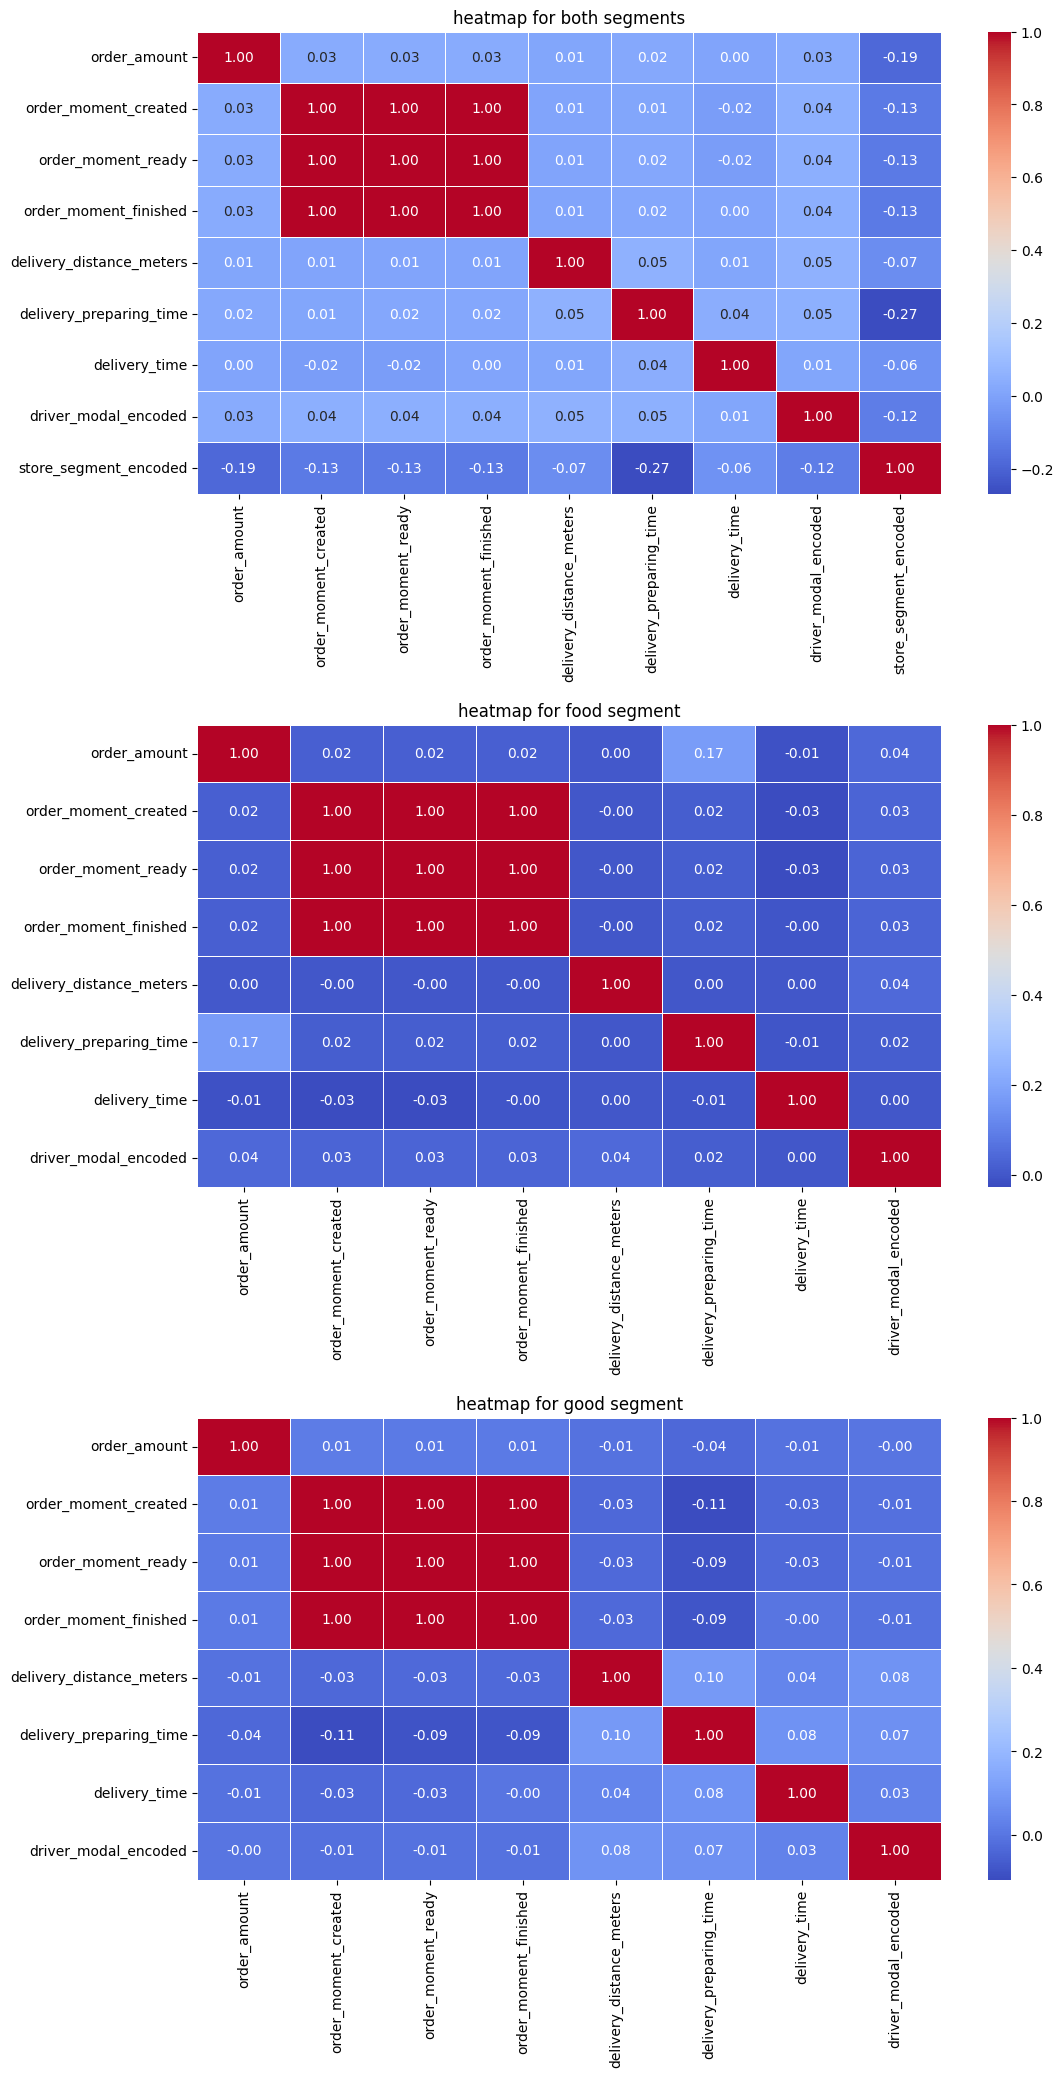

<Figure size 1000x800 with 0 Axes>

In [120]:
### heatmaps for both segment and for each of them
fig, axs = plt.subplots(3, 1, figsize=(12, 24), gridspec_kw={'hspace':0.5})
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axs[0])
sns.heatmap(food_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axs[1])
sns.heatmap(good_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axs[2])

axs[0].set_title('heatmap for both segments')
axs[1].set_title('heatmap for food segment')
axs[2].set_title('heatmap for good segment')

plt.show()

#### 3.2.3.Correlation between delivery distance and delivery time

In [16]:
### select food segment only. take only store, delivery distance, delivery time columns with rounded values 
delivery_time.filter(delivery_time['store_segment']=='FOOD').select('store_id', 'delivery_preparing_time','delivery_time','delivery_distance_meters').show()
del_time_per_s = delivery_time.groupBy('store_id').agg(F.round(F.mean('delivery_distance_meters'), 0).alias('avg_distance'), 
                                                       F.round(F.mean('delivery_time'), 0).alias('avg_delivery_time'),
                                                       F.round(F.mean('delivery_preparing_time'), 0).alias('avg_prep_time'))
del_time_per_s.show()

+--------+-----------------------+-------------+------------------------+
|store_id|delivery_preparing_time|delivery_time|delivery_distance_meters|
+--------+-----------------------+-------------+------------------------+
|    3528|                   7085|         1647|                    2122|
|     495|                    755|          898|                     793|
|     495|                    780|         3087|                     451|
|    3091|                    830|         1807|                    1365|
|     236|                    821|         1213|                    2608|
|    1037|                   1410|          791|                    1485|
|     495|                    597|         1728|                    1153|
|    2439|                   1210|          775|                    1178|
|    1057|                   2001|         2004|                    7093|
|    2948|                   1302|          734|                    1991|
|      53|                    669|    

In [17]:
print(del_time_per_s.toPandas().corr())
delivery_time.select('store_id').distinct().count()

874

In [ ]:
### 9 minutes 56 seconds 

In [65]:
### calculating correlation between delivery time and distance for each store

stores = delivery_time.select('store_id').distinct()
distance_to_time = delivery_time.select('store_id', 'delivery_distance_meters', 'delivery_time')
corrs = {}
now = datetime.now()
for idx, row in enumerate(stores.collect(), start=1):
    if idx%100==0:
        print(idx)
        
    temp_df = distance_to_time.filter(distance_to_time['store_id']==row['store_id'])
    
    corrs[row['store_id']] = temp_df.corr('delivery_distance_meters', 'delivery_time')
print(f"endtime {datetime.now()-now}")

100
200


300
400
500


600


700
800
endtime 0:09:56.240296


In [67]:
### saving csv file with correlations values to hfds
import csv

corrs = dict(sorted(corrs.items(), key=lambda item: item[1], reverse= True))

# Path to save the CSV file locally
local_path = "/tmp/distance_to_time_corr_per_store.csv"

# Write dictionary to a CSV file
with open(local_path, 'w') as f:
    writer = csv.writer(f)
    for key, value in corrs.items():
        writer.writerow([key, value])

In [68]:
# Path to upload the CSV file in HDFS
hdfs_path = "hdfs://localhost:9000/user/maciek/"

# Upload the CSV file to HDFS
!hadoop fs -put $local_path $hdfs_path

2024-04-25 14:26:24,054 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [77]:
### prepare data for plotting 
import pandas as pd

corrs_rounded = {key:round(value, 2) for key, value in corrs.items()}
df = pd.DataFrame(list(corrs_rounded.items()), columns=['store_id', 'corr_value'])

df_1 = df.groupby('corr_value').agg(stores_number=('store_id', 'count')).reset_index()
df_1.head()

,corr_value,stores_number
0,-1.00,15
1,-0.96,1
2,-0.89,1
3,-0.88,1
4,-0.81,1


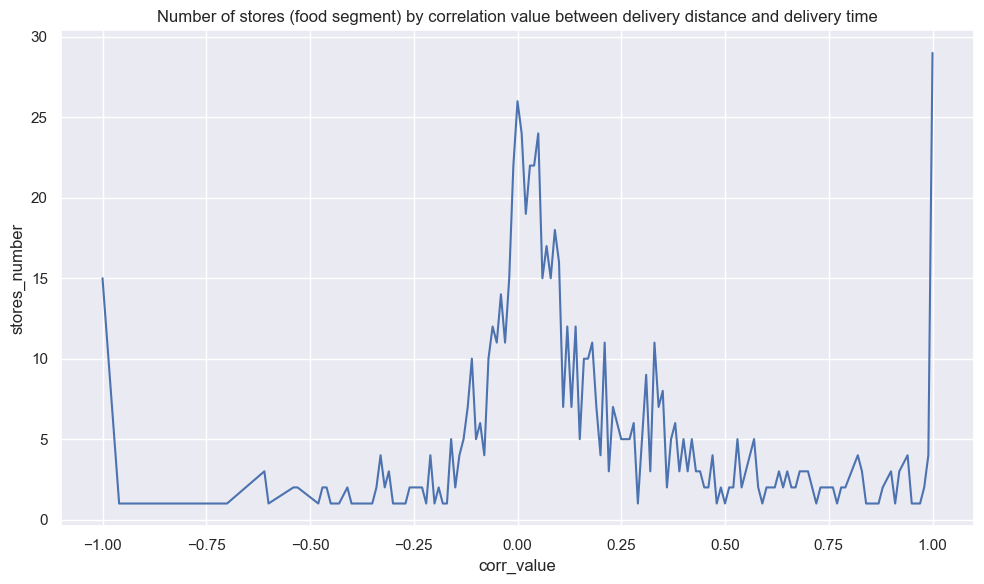

In [91]:
### Number of stores (food segment) by correlation value between delivery distance and delivery time
sns.set(rc={'figure.figsize':(10, 6)})
sns.lineplot(data=df_1, x='corr_value', y='stores_number')
plt.title('Number of stores (food segment) by correlation value between delivery distance and delivery time')
plt.tight_layout()
plt.show()

#### 3.2.4. Foods and goods orders amount plots

In [14]:
### get store segment into payments dataset
orders = dfs['orders']
orders_s = orders.join(stores, 'store_id', 'left')
orders_p = orders_s.join(payments, 'payment_order_id', 'left')
orders_done = orders_p.select('order_id', 
                              'store_id', 
                              'payment_order_id',
                              'order_status',
                              'store_segment',
                              'payment_status'
                              ).filter((orders_p['payment_status']=='PAID') &
                                       (orders_p['order_status']=='FINISHED'))
payments = payments.join(orders_done, 'payment_order_id', 'inner')
payments.show(5)

+----------------+----------+--------------+-----------+--------------+--------------+-------------+
|payment_order_id|payment_id|payment_amount|payment_fee|payment_method|payment_status|store_segment|
+----------------+----------+--------------+-----------+--------------+--------------+-------------+
|        68414309|   4427956|         106.8|       2.88|        ONLINE|          PAID|         FOOD|
|        68415344|   4427980|          95.3|       2.57|        ONLINE|          PAID|         FOOD|
|        68415457|   4427983|         148.7|       4.01|        ONLINE|          PAID|         FOOD|
|        68417787|   4428039|          72.9|       1.09|        ONLINE|          PAID|         FOOD|
|        68417787|   4428040|           5.0|        0.0|       VOUCHER|          PAID|         FOOD|
+----------------+----------+--------------+-----------+--------------+--------------+-------------+
only showing top 5 rows



In [15]:
### groupby rounded payment amount values and store segment
payments = payments.withColumn('payment_amount_rounded', F.round(payments['payment_amount'], 0))
amount = payments.groupBy('payment_amount_rounded', 'store_segment').agg(F.count('payment_amount').alias('number')).orderBy('payment_amount_rounded')
print(f"unique values: {payments.select('payment_amount_rounded').distinct().count()}")
amount.describe().show()


unique values: 1456
+-------+----------------------+-------------+------------------+
|summary|payment_amount_rounded|store_segment|            number|
+-------+----------------------+-------------+------------------+
|  count|                  2092|         2092|              2092|
|   mean|     953.3513384321224|         NULL|191.60325047801146|
| stddev|    2613.6098950098276|         NULL| 740.7732071151547|
|    min|                   0.0|         FOOD|                 1|
|    max|              100000.0|         GOOD|             20212|
+-------+----------------------+-------------+------------------+



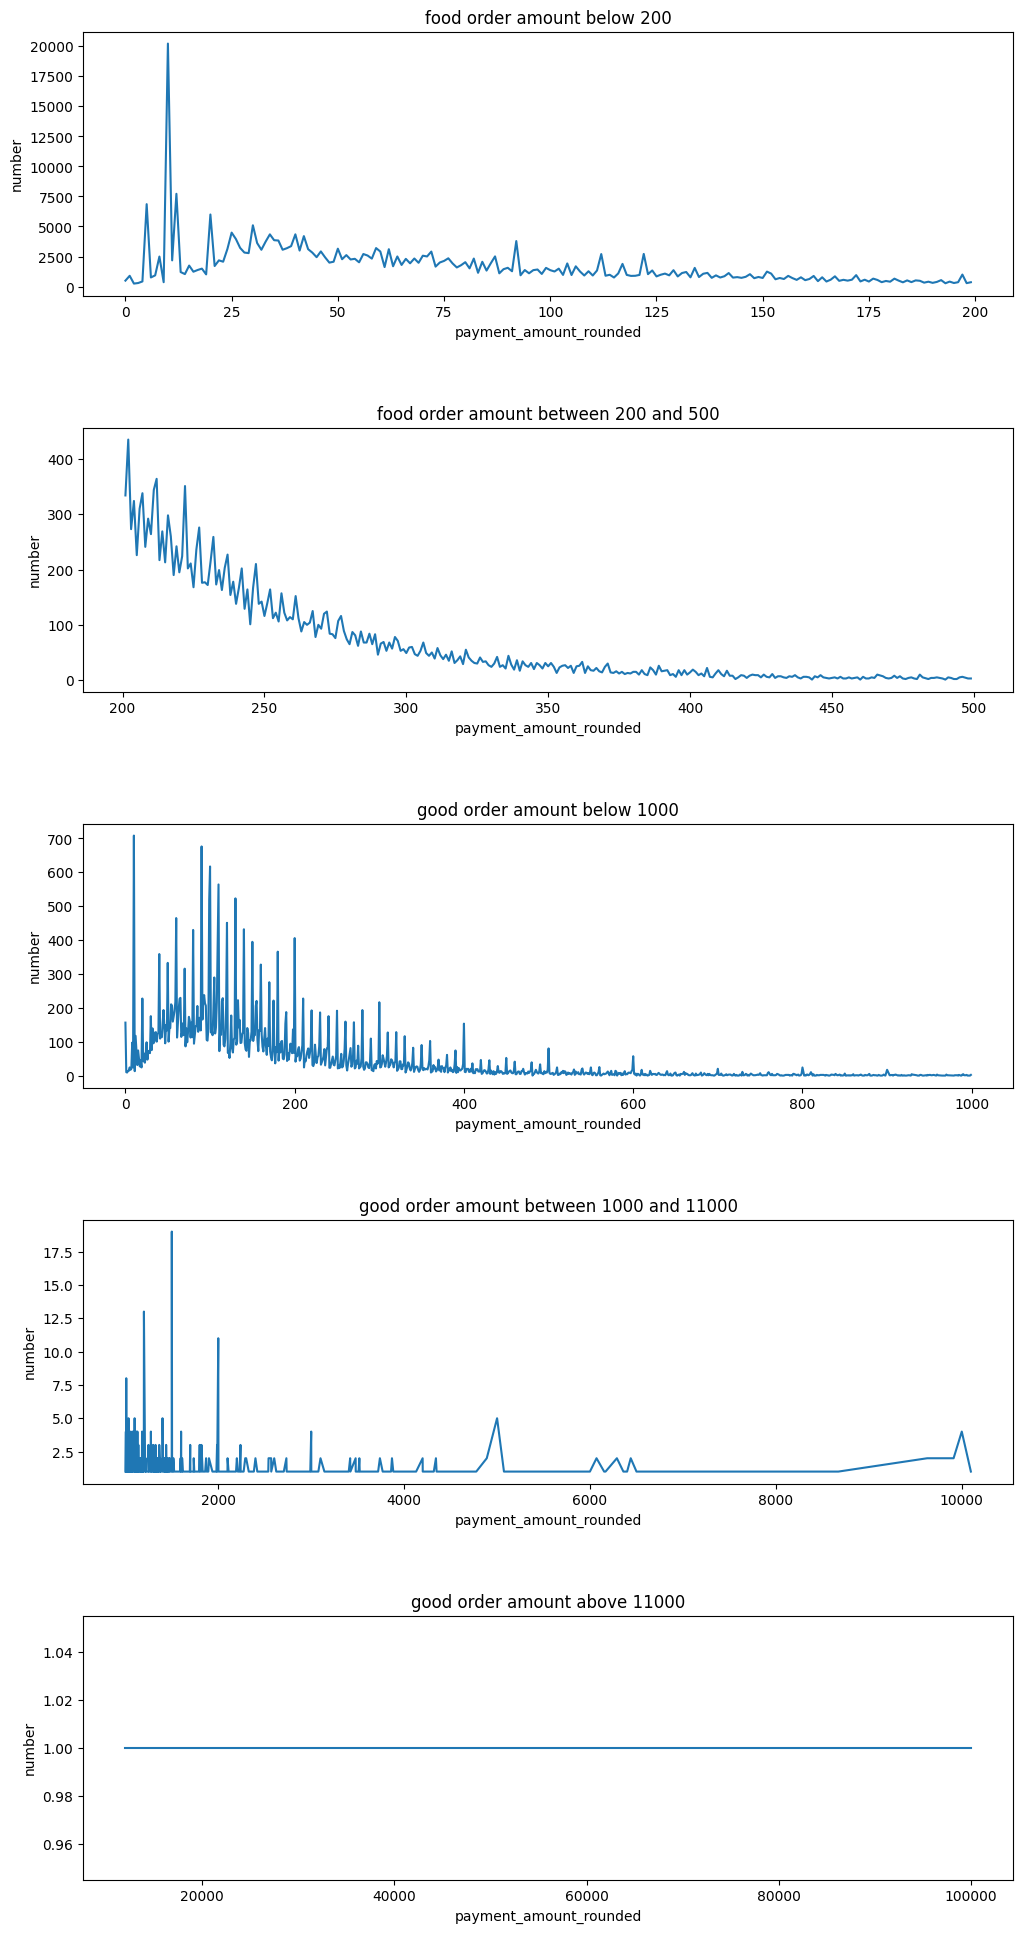

In [21]:
### plots with payment amount values per store segment

good_p_1 = amount.filter((amount['store_segment'] == 'GOOD') & (amount['payment_amount_rounded']<1000))
good_p_2 = amount.filter((amount['store_segment'] == 'GOOD') & 
                         (amount['payment_amount_rounded']>1000) &
                         (amount['payment_amount_rounded']<11000))
good_p_3 = amount.filter((amount['store_segment'] == 'GOOD') & (amount['payment_amount_rounded']>11000))
good_1 = good_p_1.toPandas()
good_2 = good_p_2.toPandas()
good_3 = good_p_3.toPandas()

food_p_1 = amount.filter((amount['store_segment'] == 'FOOD') & (amount['payment_amount_rounded']<200))
food_p_2 = amount.filter((amount['store_segment'] == 'FOOD') & 
                         (amount['payment_amount_rounded']>200) &
                         (amount['payment_amount_rounded']<500))
food_p_3 = amount.filter((amount['store_segment'] == 'FOOD') & (amount['payment_amount_rounded']>500))
food_1 = food_p_1.toPandas()
food_2 = food_p_2.toPandas()

fig, axs = plt.subplots(5, 1, figsize=(12, 24), gridspec_kw={'hspace':0.5})
sns.lineplot(data = food_1, x='payment_amount_rounded', y='number', ax=axs[0])
sns.lineplot(data = food_2, x='payment_amount_rounded', y='number', ax=axs[1])
sns.lineplot(data = good_1, x='payment_amount_rounded', y='number', ax=axs[2])
sns.lineplot(data = good_2, x='payment_amount_rounded', y='number', ax=axs[3])
sns.lineplot(data = good_3, x='payment_amount_rounded', y='number', ax=axs[4])

axs[0].set_title('food order amount below 200')
axs[1].set_title('food order amount between 200 and 500')
axs[2].set_title('good order amount below 1000')
axs[3].set_title('good order amount between 1000 and 11000')
axs[4].set_title('good order amount above 11000')

plt.show()
food_ab_500 = food_p_3.orderBy(food_p_3['payment_amount_rounded'].desc())

In [22]:
food_ab_500.show(25)

+----------------------+-------------+------+
|payment_amount_rounded|store_segment|number|
+----------------------+-------------+------+
|                1932.0|         FOOD|     1|
|                1080.0|         FOOD|     1|
|                1050.0|         FOOD|     1|
|                1017.0|         FOOD|     1|
|                 962.0|         FOOD|     1|
|                 949.0|         FOOD|     1|
|                 944.0|         FOOD|     1|
|                 934.0|         FOOD|     1|
|                 931.0|         FOOD|     1|
|                 924.0|         FOOD|     1|
|                 902.0|         FOOD|     1|
|                 886.0|         FOOD|     1|
|                 873.0|         FOOD|     1|
|                 828.0|         FOOD|     1|
|                 820.0|         FOOD|     1|
|                 813.0|         FOOD|     1|
|                 800.0|         FOOD|     1|
|                 794.0|         FOOD|     1|
|                 793.0|         F

#### 3.2.5....

In [ ]:
### get only done orders
orders = dfs['orders']
orders_s = orders.join(stores, 'store_id', 'left')
orders_p = orders_s.join(payments, 'payment_order_id', 'left')
orders_done = orders_p.select('order_id', 
                               'store_id', 
                               'payment_order_id',
                               'delivery_order_id',
                               'order_status',
                               'order_moment_created', 
                               'order_moment_ready', 
                               'order_moment_finished',
                               'store_segment',
                               'payment_status'
                              ).filter((orders_p['payment_status']=='PAID') &
                                       (orders_p['order_status']=='FINISHED'))

orders_done_food = orders_done.filter(orders_done['store_segment']=='FOOD')
orders_done_good = orders_done.filter(orders_done['store_segment']=='GOOD')

### total null values number in each column

tot_nan_vls = orders_done_good.select(*(F.sum(F.col(c).isNull().cast("int")).alias(c) for c in orders_done.columns)).collect()[0].asDict()
print("number of null values in each column\n")
for k, v in tot_nan_vls.items():
    print(k, v)


## 4.Stop Pyspark session

In [ ]:
spark.stop()